In [1]:
%pylab inline
import os
import downglacier.sandbox.tcd_utils as utils
import downglacier.graphics as dgplot
import seaborn as sns
import pandas as pd
import downglacier.sandbox.tcd_utils as utils
from datetime import datetime as dt
pal = sns.color_palette('pastel')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


# APPENDIX Figures

In [2]:
wd = utils.run_checkinput_allz(run=False)
odir = os.path.join(wd, 'output')

In [3]:
sdf = pd.read_csv(os.path.join(odir, 'checkinput', 'precheck-results.csv'), index_col=0)
sdf = sdf[sdf.varname == 'mbtotfromsum']
sdf['z'] = [s.split('_')[1] for s in sdf.index]
sdscores = sdf.set_index('z')
sdf = pd.read_csv(os.path.join(odir, 'checkinput', 'predictands_stats.csv'), index_col=0)
sdf = sdf.loc[['airtemp' in s for s in sdf.index]]
sdf['z'] = [s.split('_')[1] for s in sdf.index]
sdscores['temp'] = sdf.set_index('z')['mean']

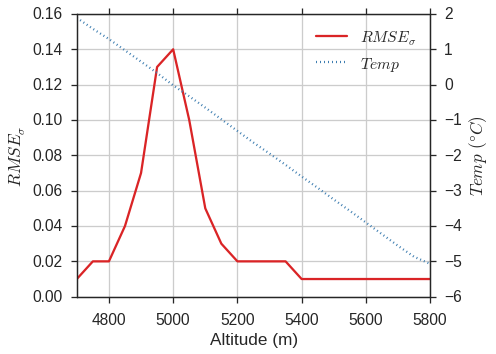

In [4]:
pal = sns.color_palette('Set1', n_colors=6, desat=0.9)
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

lns1 = ax1.plot(sdscores.index, sdscores['fullmodel_percsigma'], '-', color=pal[0], label='$RMSE_{\sigma}$')
lns2 = ax2.plot(sdscores.index, sdscores['temp'], ':', color=pal[1], label='$Temp$')

ax1.set_xlabel('Altitude (m)')
ax1.set_ylabel(u'$RMSE_{\sigma}$')
ax2.set_ylabel(u'$Temp\, (\degree C)$')
ax1.grid()
ax1.set_xlim([4700, 5800])

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right', frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(utils.get_plot_dir(), 'app1.pdf'))

## CROSS VAL

In [5]:
wd = utils.run_standard(run=False)
odir = os.path.join(wd, 'output')

In [6]:
# Variables to keep
fluxu = u'$W\: m^{-2}$'
massu = u'$kg\: m^{-2}\: month^{-1}$'
keep = OrderedDict()
keep[u'airtemp_4750_ds'] = (u'$Temp$', u'$K$')
keep[u'vp_4750_ds'] = (u'$VP$', u'$hPa$')
keep[u'ws_4750_ds'] = (u'$WS$', u'$m\: s^{-1}$')
keep[u'swin_4750_ds'] = (u'$SW_{in}$', fluxu)
keep[u'swout_4750_ds'] = (u'$SW_{out}$', fluxu)
keep[u'lwin_4750_ds'] = (u'$LW_{in}$', fluxu)
keep[u'lwout_4750_ds'] = (u'$LW_{out}$', fluxu)
keep[u'qs_4750_ds'] = (u'$Q_{S}$', fluxu)
keep[u'ql_4750_ds'] = (u'$Q_{L}$', fluxu)
keep[u'qc_4750_ds'] = (u'$Q_{C}$', fluxu)
keep[u'qps_4750_ds'] = (u'$Q_{PS}$', fluxu)
keep[u'subsurfmass_4750_ds'] = (u'$M_{Sub}$', massu)
keep[u'prcpsol_4750_ds'] = (u'$PRCP_{Solid}$', massu)
keep[u'prcptot_4750_ds'] = (u'$PRCP_{Total}$', massu)

In [7]:
names = ['Full Model', 'CrossVal', 'Outer CrossVal']
df = pd.read_csv(os.path.join(odir, 'screening', 'results.csv'), index_col=0)
df = df.T[list(keep.keys())].T
dfo = df[['fullmodel_skillscore', 'cv_skillscore', 'outercv_skillscore']].copy()
dfo.columns = names
dfo['Exp'] = np.repeat('Lasso', len(dfo))
c = []
for e in names:
    tdf = dfo[[e, 'Exp']].copy()
    tdf.columns = ['Score', 'Exp']
    tdf['Model'] = np.repeat(e, len(dfo))
    c.append(tdf)
dfo = pd.concat(c)

In [8]:
f = os.path.join(utils.run_sensis(run=False), 'method', 'step_rmse_l1o', 'screening', 'results.csv')
df = pd.read_csv(f, index_col=0)
df = df.T[list(keep.keys())].T
dfa = df[['fullmodel_skillscore', 'cv_skillscore', 'outercv_skillscore']].copy()
dfa.columns = names
dfa['Exp'] = np.repeat('Stepwise', len(dfa))
c = []
for e in names:
    tdf = dfa[[e, 'Exp']].copy()
    tdf.columns = ['Score', 'Exp']
    tdf['Model'] = np.repeat(e, len(dfa))
    c.append(tdf)
dfa = pd.concat(c)

In [9]:
df = pd.concat([dfo, dfa])

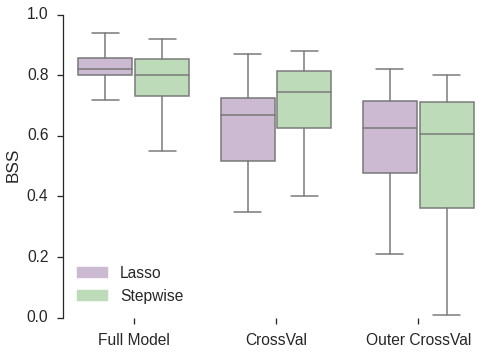

In [16]:
g = sns.factorplot("Model", "Score", "Exp", df, kind="box",
                   palette="PRGn", legend=False,
                   x_order=names)
g.set_axis_labels('', 'BSS')
ax = g.axes[0][0]
ax.legend(loc='lower left')
ax.set_ylim([0, 1])
g.despine(bottom=True)
g.fig.set_size_inches(7,5)
g.fig.tight_layout()
plt.savefig(os.path.join(utils.get_plot_dir(), 'app2.pdf'))